# III. Exploratory Analysis and Feature Selection

Date: 25/07/2019

In this notebook the different main variable groups are analysed and relevant features selected.

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from scipy.stats import iqr

# For Univariate Analysis:
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from scipy.stats.mstats import kruskalwallis

# For RFE:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, fbeta_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

## 0. Loading the train data

We load the train dataset that we have previously preprocessed:

In [2]:
train = pd.read_csv('output/train.csv',
                   parse_dates = ['ANNDT_ACT','FPEDATS','STATPERS'])

In [3]:
print('The dimensions of the train set are: %s' % str(train.shape))
print('Interval of time covered by TRAIN: %s to %s' % (min(train.FPEDATS),max(train.FPEDATS)))

The dimensions of the train set are: (1609, 47)
Interval of time covered by TRAIN: 2000-01-31 00:00:00 to 2014-12-31 00:00:00


Here we are going to work first with the FE target variable:

In [4]:
# Define the target variable:
target = 'FEC'

In [5]:
# Sort dataset by date and TICKER:
train.sort_values(['FPEDATS','TICKER'], inplace=True)
train.reset_index(drop=True, inplace=True)

In [6]:
train.head()

,TICKER,FPEDATS,ANNDT_ACT,ACTUAL,STATPERS,MEDEST,year,FEC,size_pct,size_group,...,lt_debt,npm,pay_turn,pe_exi,ptb,quick_ratio,rect_turn,roa,roce,roe
0,DYCO,2000-01-31,2000-02-28,0.2500,2000-02-17,0.25,2000,2,0.602214,3.0,...,-0.841829,0.875740,1.105795,0.854987,2.715922,1.817134,0.009340,2.274143,1.492170,0.531469
1,HVN,2000-01-31,2000-03-09,0.0750,2000-02-17,0.06,2000,2,0.118002,1.0,...,0.562969,0.011834,0.263393,-0.098865,-0.447169,0.000000,3.703222,0.180685,0.000000,-0.045455
2,TOLL,2000-01-31,2000-02-24,0.1525,2000-02-17,0.14,2000,2,0.452258,2.0,...,0.311094,0.674556,0.925985,-0.029462,0.182287,0.000000,0.000000,0.246106,0.261745,0.138112
3,WHIN,2000-01-31,2000-02-22,0.3300,2000-02-17,0.35,2000,2,0.065103,1.0,...,0.107946,-0.017751,0.236829,-0.099853,-0.268753,0.000000,0.000000,0.457944,0.451902,0.150350
4,KBH,2000-02-29,2000-03-20,0.3300,2000-03-16,0.27,2000,2,0.552271,2.0,...,0.510495,0.112426,0.186720,0.083348,0.620745,0.000000,0.126696,0.283489,0.181208,0.538462


## 1. Feature Selection

Here first the different elements to perform feature selection are defined, later they are applied to the different groups of variables

### 1.1. Univariate Analysis

Here 4 different tests are considered:

    ANOVA F-test
    ANOVA Kruskal Wallis Test
    Chi-Squared
    Mutual Information
    
First, a function for plotting the variable distributions is created:

In [7]:
def drop_outliers(data,feature):
    data = data.loc[np.absolute(data[feature] - data[feature].median()) < 5*iqr(data[feature])]
    return data

In [8]:
def plot_var_dist(data,features,nrow,ncol,figsize,drop_outl=False):
    # Drop outliers:
    if drop_outl == True:
        for feature in features:
            data = drop_outliers(data,feature)
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(nrows=nrow, ncols=ncol)
    for i, feature in enumerate(data[features]):
        ax = plt.subplot(gs[i])
        sns.distplot(data[feature][data.FEC == 1], bins=50, label='Negative Surprise')
        sns.distplot(data[feature][data.FEC == 2], bins=50, label='No Surprise')
        sns.distplot(data[feature][data.FEC == 3], bins=50, label='Positive Surprise')
        ax.set_xlabel('')
        ax.set_title('Feature: ' + str(feature))
    ax.legend(loc='best')
    plt.show()   

Second, a function to perform the Kruskal Wallis test:

In [9]:
def KW_test(data,features):
    # Create list to store values:
    l_stat = []
    l_pval = []
    
    # Compute the KW test to each feature:
    for feature in features:
        # Create samples:
        neg_sur = np.array(data[feature].loc[data.FEC == 1])
        no_sur = np.array(data[feature].loc[data.FEC == 2])
        pos_sur = np.array(data[feature].loc[data.FEC == 3])

        # Compute KW test:
        KWstat, pval = kruskalwallis(neg_sur,no_sur,pos_sur)

        # Add to list:
        l_stat.append(KWstat)
        l_pval.append(pval)
        
    return l_stat,l_pval

And a function to compute all the tests:

In [10]:
def compute_tests(data,target,features):
    # Create the data frame:
    df = pd.DataFrame({'Variable':features})
    
    # One-Way ANOVA:
    ANOVA_Fstat, ANOVA_pval = f_classif(data[features],data[target])
    df['ANOVA_Fstat'] = ANOVA_Fstat
    df['ANOVA_pval'] = ANOVA_pval
    
    # Kruskal Wallis test:
    KWstat, KWpval = KW_test(data,features)
    df['KW_stat'] = KWstat
    df['KW_pval'] = KWpval
    
    # Mutual Information:
    MI = mutual_info_classif(data[features],data[target],
                                           n_neighbors=3)
    df['Mutual Info'] = MI
    
    return df

### 1.2. Recursive Feature Selection

As a second stage we are going to perform RFE CV in 5-folds with TimeSeriesSplit. First, create a function to perform the RFE CV:

In [11]:
def x_y_split(data,target,features):
    y_train = data[target]
    X_train = data[features]
    return y_train, X_train

In [12]:
def rfe_cv(X_train,y_train,model,metrics):

    # Scale the data:
    scaler = StandardScaler()
    X_sc = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_sc, columns=X_train.columns)
    
    # Define CV object:
    rfe_cv = RFECV(model,
                   cv = TimeSeriesSplit(n_splits=5),
                   scoring = metrics,
                   min_features_to_select=1,
                   n_jobs = -1)
    
    # Fit to the data:
    rfe_cv = rfe_cv.fit(X_train,y_train)
    
    # Return the selected features:
    selected_features = X_train.columns[rfe_cv.get_support()]
    
    return selected_features

Define the models to be used:

In [13]:
# Logistic Regression:
logreg = LogisticRegression(solver = 'lbfgs',
                            random_state = 7777,
                            multi_class = 'multinomial',
                            class_weight = 'balanced',
                            max_iter = 1000)

# Random Forest:
randomforest = RandomForestClassifier(n_jobs=-1,
                                      random_state = 7777,
                                      max_features = 'sqrt',
                                      bootstrap = True,
                                      criterion = 'entropy',
                                      class_weight = 'balanced',
                                      oob_score = False)


And then define the metric to evaluate the models:

In [14]:
# Define the metrics to be evaluated in:
f_macro = make_scorer(fbeta_score, beta=0.5, average='macro')

## 2. Results

### 2.1. Technical Variables

First, let's keep only the relevant data sub-sample:

In [15]:
t = train[['FEC','size_pct','FECq1','FECq2','FECq3','FECq4','AFD1','AFD2','AFD3']]
print(t.shape)

(1609, 9)


Plot the distributions:

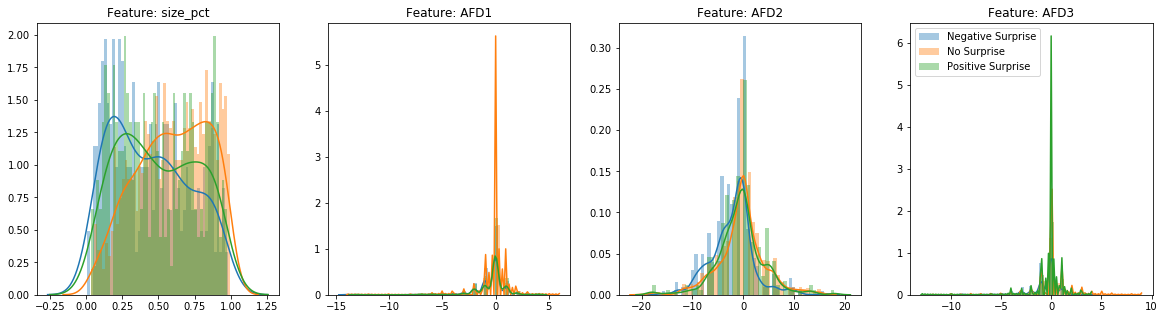

In [16]:
figsize = (20,5)
plot_var_dist(t,['size_pct','AFD1','AFD2','AFD3'],1,4,figsize)

Make the tests for size and AFD:

In [17]:
np.round(compute_tests(t,target,['size_pct','AFD1','AFD2','AFD3']),3)

,Variable,ANOVA_Fstat,ANOVA_pval,KW_stat,KW_pval,Mutual Info
0,size_pct,49.291,0.000,88.295,0.000,0.042
1,AFD1,4.833,0.008,13.450,0.001,0.000
2,AFD2,17.242,0.000,51.155,0.000,0.018
3,AFD3,9.549,0.000,30.810,0.000,0.012


And make a chi-squared test for the lagging quarters:

In [18]:
# Compute Chi-squared test:
chi2_stat, chi2_pval = chi2(t[['FECq1','FECq2','FECq3','FECq4']],t['FEC'])
mi = mutual_info_classif(train[['FECq1','FECq2','FECq3','FECq4']],train[target],n_neighbors=3)

pd.DataFrame({'Variable':['FECq1','FECq2','FECq3','FECq4'],
              'Chi2 stat':chi2_stat,
              'Chi2 pval':chi2_pval,
              'Mutual Information': mi})

,Variable,Chi2 stat,Chi2 pval,Mutual Information
0,FECq1,18.825699,0.000082,0.092590
1,FECq2,5.982985,0.050212,0.058520
2,FECq3,3.923522,0.140611,0.039549
3,FECq4,5.388555,0.067591,0.053966


### 2.2 Global Risk factor variables

First, let's keep only the relevant data sub-sample:

In [19]:
grf = ['gni','tbill1Y','ppi_mat','ppi_mach','cs_pub','cs_pri','unemp_excess','pr_pv']
print(train[grf].shape)

(1609, 8)


In [20]:
train[grf].describe()

,gni,tbill1Y,ppi_mat,ppi_mach,cs_pub,cs_pri,unemp_excess,pr_pv
count,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000
mean,0.042422,-0.070941,0.028357,0.026098,0.035442,0.021096,0.180422,-0.777471
std,0.024365,0.525293,0.037255,0.017348,0.061974,0.122436,0.838875,3.266645
min,-0.019469,-0.889222,-0.089104,-0.005214,-0.090775,-0.250791,-1.000000,-10.977647
25%,0.030308,-0.428571,0.010422,0.013210,-0.015387,-0.073273,-0.299213,-1.204006
50%,0.046637,-0.263158,0.022070,0.023256,0.036408,0.043353,-0.040000,-0.059806
75%,0.067971,0.270270,0.042644,0.036972,0.083879,0.126815,0.380952,0.232661
max,0.071677,1.791667,0.127038,0.078494,0.192704,0.207399,4.000000,5.076408


Plot the distributions:

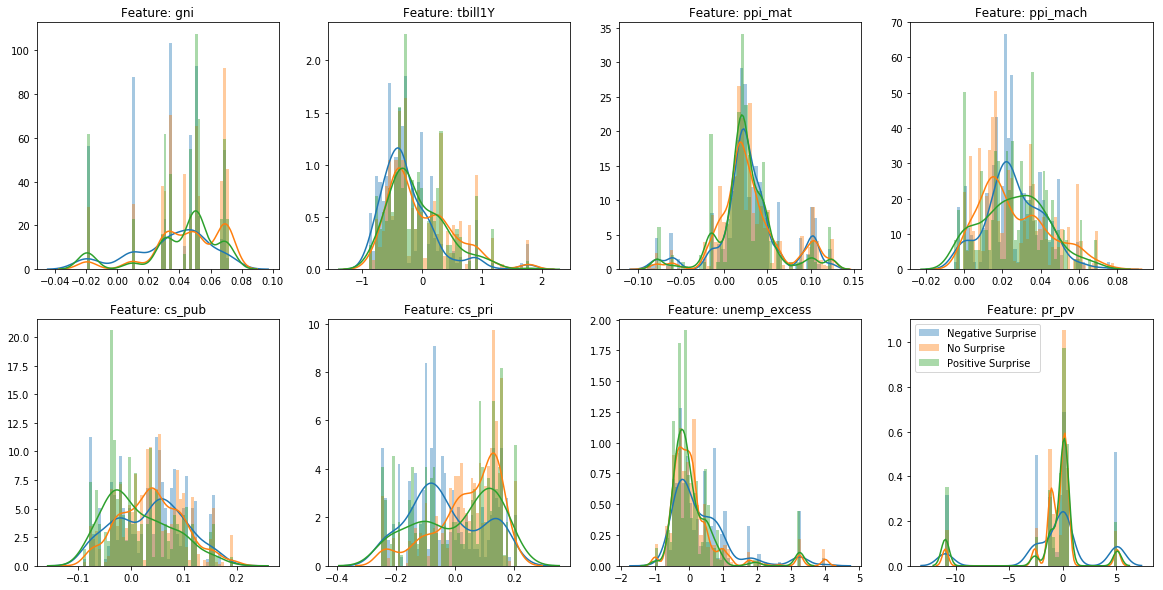

In [21]:
figsize = (20,10)
plot_var_dist(train,grf,2,4,figsize)

A destacar:

- La mayor parte de ellas dificil argumentar que esta normalmente distribuidas
- CS_PRI es interesante, CS_PUB en menor medida
- GNI y PR_PV se pueden sacar directamente del analisis

And compute the tests:

In [22]:
np.round(compute_tests(train,target,grf),3)

,Variable,ANOVA_Fstat,ANOVA_pval,KW_stat,KW_pval,Mutual Info
0,gni,27.055,0.000,50.710,0.000,0.071
1,tbill1Y,21.500,0.000,47.567,0.000,0.074
2,ppi_mat,1.682,0.186,3.137,0.208,0.083
3,ppi_mach,0.011,0.989,2.750,0.253,0.091
4,cs_pub,17.810,0.000,37.892,0.000,0.086
5,cs_pri,52.148,0.000,85.274,0.000,0.099
6,unemp_excess,10.452,0.000,23.165,0.000,0.076
7,pr_pv,1.659,0.191,0.538,0.764,0.063


Perform the RFE:

In [23]:
print('RFE for Logistic Regression:')
print(list(rfe_cv(train[grf], train['FEC'], logreg,f_macro)))
print('RFE for Random Forest:')
print(list(rfe_cv(train[grf], train['FEC'], randomforest, f_macro)))

RFE for Logistic Regression:
['gni', 'tbill1Y', 'ppi_mat', 'ppi_mach', 'cs_pub', 'cs_pri', 'pr_pv']
RFE for Random Forest:
['ppi_mach', 'cs_pri']


## 3. Intrinsic Variables: ndelay & Financial Ratios

First, I'll analyze ndelay and later the Financial Ratios as a whole and by groups.

### 3.1. N-delay

Here I do the same analysis but compressed to save space:

In [24]:
nd = train[['FEC','ndelay']]

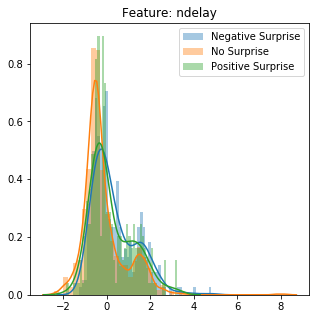

In [25]:
figsize = (5,5)
plot_var_dist(nd,['ndelay'],1,1,figsize)

And the tests:

In [26]:
np.round(compute_tests(nd,target,['ndelay']),3)

,Variable,ANOVA_Fstat,ANOVA_pval,KW_stat,KW_pval,Mutual Info
0,ndelay,32.611,0.0,91.825,0.0,0.068


### 3.2. Financial Ratios

First, lets consider all as a whole for the RFE and then analyze them by dimension:

In [27]:
# Financial Ratios by dimension:
capitalization = ['capital_ratio','intcov_ratio','de_ratio','debt_assets']
efficency = ['at_turn','inv_turn','pay_turn','rect_turn']
financial_soundness = ['cash_debt','debt_ebitda','int_totdebt','lt_debt']
liquidity = ['curr_ratio','quick_ratio']
profitability = ['npm','roa','roce','roe']
valuation = ['evm','pe_exi','ptb']

In [28]:
# Create a list with all financial ratios:
fr = [capitalization, efficency,financial_soundness,liquidity,profitability,valuation]
fr = train[[val for sublist in fr for val in sublist]].columns

Compute all the tests:

In [29]:
np.round(compute_tests(train,target,fr),3)

,Variable,ANOVA_Fstat,ANOVA_pval,KW_stat,KW_pval,Mutual Info
0,capital_ratio,30.572,0.000,49.227,0.000,0.022
1,intcov_ratio,4.730,0.009,190.833,0.000,0.090
2,de_ratio,2.841,0.059,7.394,0.025,0.045
3,debt_assets,16.079,0.000,12.673,0.002,0.039
4,at_turn,26.165,0.000,64.402,0.000,0.039
5,inv_turn,4.700,0.009,28.121,0.000,0.052
6,pay_turn,2.435,0.088,7.015,0.030,0.000
7,rect_turn,4.479,0.011,1.884,0.390,0.039
8,cash_debt,6.972,0.001,8.695,0.013,0.028
9,debt_ebitda,6.193,0.002,17.328,0.000,0.095


And the RFE:

In [30]:
print('RFE for Logistic Regression:')
print(list(rfe_cv(train[fr], train[target], logreg, f_macro)))
print('RFE for Random Forest:')
print(list(rfe_cv(train[fr], train[target], randomforest, f_macro)))

RFE for Logistic Regression:
['capital_ratio', 'inv_turn', 'debt_ebitda', 'int_totdebt', 'roa', 'evm', 'ptb']
RFE for Random Forest:
['capital_ratio', 'intcov_ratio', 'debt_assets', 'at_turn', 'inv_turn', 'pay_turn', 'debt_ebitda', 'lt_debt', 'npm', 'roa', 'roce', 'roe', 'evm', 'pe_exi', 'ptb']


#### 3.2.1. Capitalization Ratios

Plot the distributions:

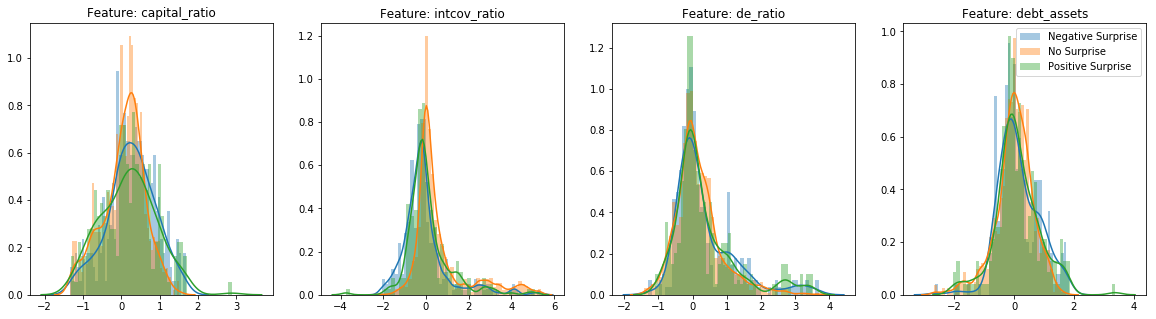

In [31]:
figsize = (20,5)
plot_var_dist(train,capitalization,1,4,figsize,drop_outl=True)

Compute the univariate tests:

In [32]:
np.round(compute_tests(train,target,capitalization),3)

,Variable,ANOVA_Fstat,ANOVA_pval,KW_stat,KW_pval,Mutual Info
0,capital_ratio,30.572,0.000,49.227,0.000,0.030
1,intcov_ratio,4.730,0.009,190.833,0.000,0.089
2,de_ratio,2.841,0.059,7.394,0.025,0.044
3,debt_assets,16.079,0.000,12.673,0.002,0.036


Perform RFE with the 2 different models:

In [33]:
print('RFE for Logistic Regression:')
print(list(rfe_cv(train[capitalization], train[target], logreg, f_macro)))
print('RFE for Random Forest:')
print(list(rfe_cv(train[capitalization], train[target], randomforest, f_macro)))

RFE for Logistic Regression:
['capital_ratio', 'intcov_ratio']
RFE for Random Forest:
['intcov_ratio']


#### 3.2.2. Efficiency Ratios

Plot the distributions:

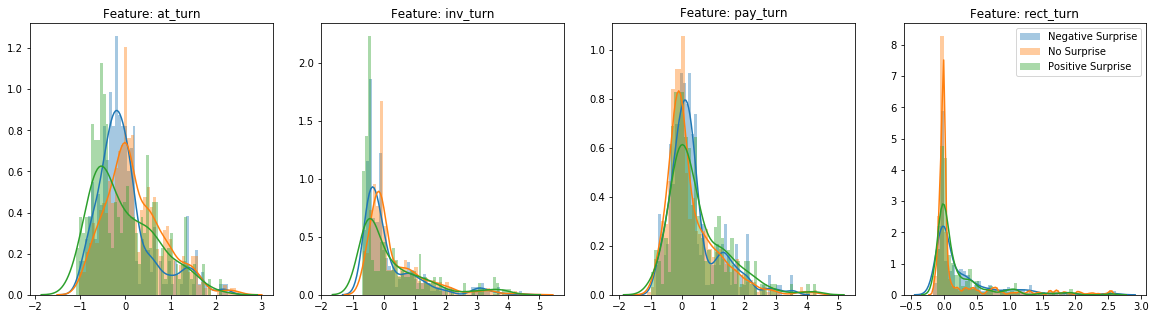

In [34]:
figsize = (20,5)
plot_var_dist(train,efficency,1,4,figsize,drop_outl=True)

Compute the univariate tests:

In [35]:
np.round(compute_tests(train,target,efficency),3)

,Variable,ANOVA_Fstat,ANOVA_pval,KW_stat,KW_pval,Mutual Info
0,at_turn,26.165,0.000,64.402,0.00,0.037
1,inv_turn,4.700,0.009,28.121,0.00,0.053
2,pay_turn,2.435,0.088,7.015,0.03,0.000
3,rect_turn,4.479,0.011,1.884,0.39,0.044


And RFE:

In [36]:
print('RFE for Logistic Regression:')
print(list(rfe_cv(train[efficency], train[target], logreg, f_macro)))
print('RFE for Random Forest:')
print(list(rfe_cv(train[efficency], train[target], randomforest, f_macro)))

RFE for Logistic Regression:
['at_turn', 'inv_turn', 'pay_turn', 'rect_turn']
RFE for Random Forest:
['at_turn', 'inv_turn']


### 3.4. Financial Soundness

Plot the distributions:

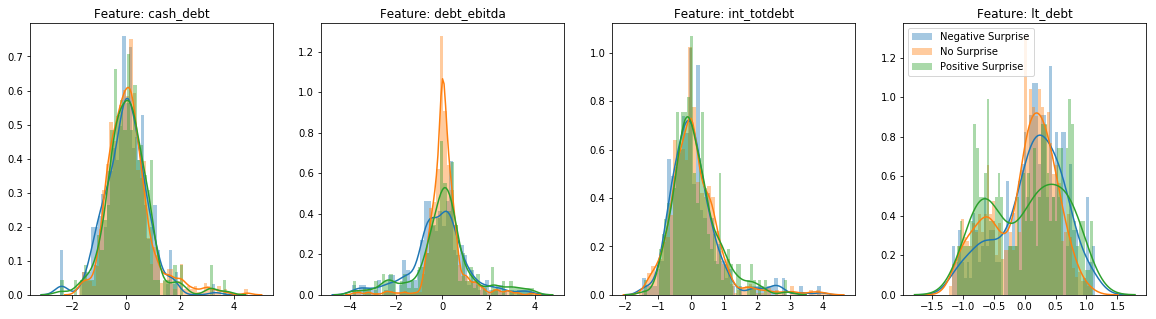

In [37]:
figsize = (20,5)
plot_var_dist(train,financial_soundness,1,4,figsize,drop_outl=True)
#plot_var_dist(fs,fs.columns[1:],2,2)

Compute the univariate tests:

In [38]:
np.round(compute_tests(train,target,financial_soundness),3)

,Variable,ANOVA_Fstat,ANOVA_pval,KW_stat,KW_pval,Mutual Info
0,cash_debt,6.972,0.001,8.695,0.013,0.026
1,debt_ebitda,6.193,0.002,17.328,0.000,0.095
2,int_totdebt,1.413,0.244,1.536,0.464,0.018
3,lt_debt,23.907,0.000,52.021,0.000,0.009


And RFE:

In [39]:
print('RFE for Logistic Regression:')
print(list(rfe_cv(train[financial_soundness], train[target], logreg, f_macro)))
print('RFE for Random Forest:')
print(list(rfe_cv(train[financial_soundness], train[target], randomforest, f_macro)))

RFE for Logistic Regression:
['cash_debt', 'debt_ebitda', 'int_totdebt', 'lt_debt']
RFE for Random Forest:
['debt_ebitda', 'lt_debt']


### 2.5. Liquidity Ratios

Here I do the same analysis but compressed to save space:

In [40]:
# Keep only liquidity ratios:
fr_keep = [['FEC'],liquidity]
l = train[[val for sublist in fr_keep for val in sublist]]

In [41]:
# Take out the imputed NAs:
l = l.loc[l.curr_ratio >0]
l = l.loc[l.quick_ratio >0]

## These variables where sparsely populated (>50% NAs) but relevant, and were imputed by industry median

Plot the distributions:

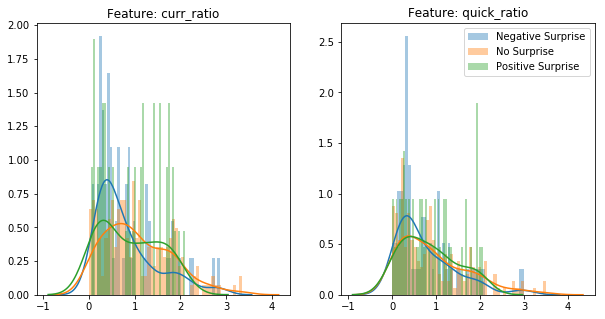

In [42]:
figsize = (10,5)
plot_var_dist(l,l.columns[1:],1,2,figsize)

Compute the univariate tests:

In [43]:
np.round(compute_tests(l,target,liquidity),3)

,Variable,ANOVA_Fstat,ANOVA_pval,KW_stat,KW_pval,Mutual Info
0,curr_ratio,3.787,0.024,7.802,0.020,0.041
1,quick_ratio,1.438,0.239,2.096,0.351,0.000


And RFE:

In [44]:
print('RFE for Logistic Regression:')
print(list(rfe_cv(train[liquidity], train['FEC'], logreg, f_macro)))
print('RFE for Random Forest:')
print(list(rfe_cv(train[liquidity], train['FEC'], randomforest, f_macro)))

RFE for Logistic Regression:
['curr_ratio', 'quick_ratio']
RFE for Random Forest:
['curr_ratio']


### 3.6. Profitability Ratios

Plot the distributions:

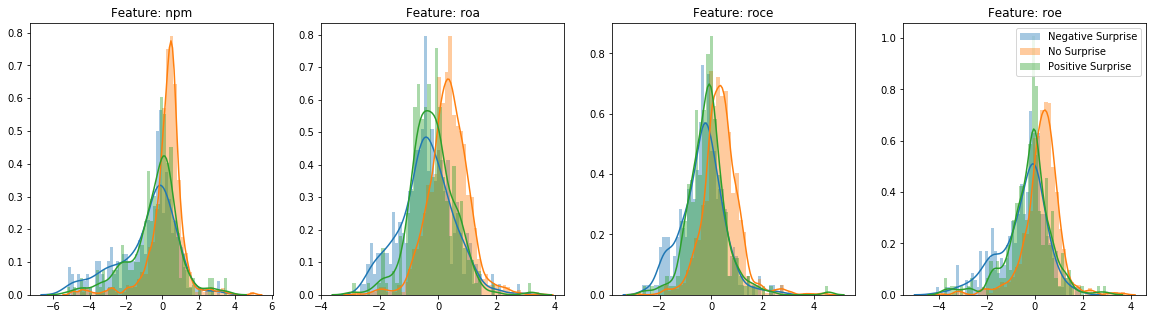

In [45]:
figsize = (20,5)
plot_var_dist(train,profitability,1,4,figsize,drop_outl=True)

Compute the univariate tests:

In [46]:
np.round(compute_tests(train,target,profitability),3)

,Variable,ANOVA_Fstat,ANOVA_pval,KW_stat,KW_pval,Mutual Info
0,npm,103.722,0.0,230.241,0.0,0.074
1,roa,152.867,0.0,282.164,0.0,0.086
2,roce,128.398,0.0,301.434,0.0,0.114
3,roe,107.450,0.0,275.798,0.0,0.096


And RFE:

In [47]:
print('RFE for Logistic Regression:')
print(list(rfe_cv(train[profitability], train['FEC'], logreg, f_macro)))
print('RFE for Random Forest:')
print(list(rfe_cv(train[profitability], train['FEC'], randomforest, f_macro)))

RFE for Logistic Regression:
['npm', 'roa', 'roce', 'roe']
RFE for Random Forest:
['roce']


### 3.7. Valuation Ratios

Plot the distributions:

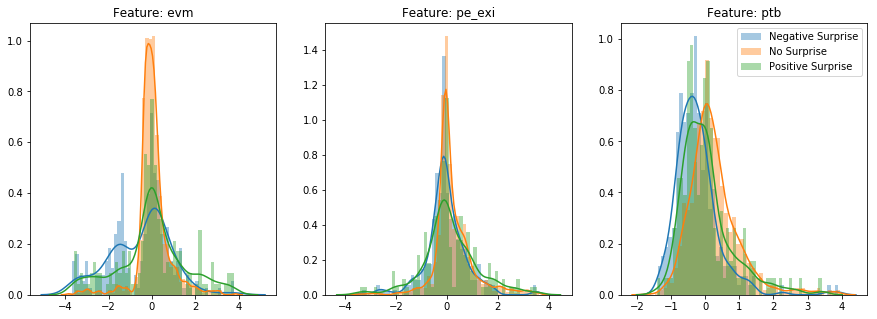

In [48]:
figsize = (15,5)
plot_var_dist(train,valuation,1,3,figsize,drop_outl=True)

Compute the univariate tests:

In [49]:
np.round(compute_tests(train,target,valuation),3)

,Variable,ANOVA_Fstat,ANOVA_pval,KW_stat,KW_pval,Mutual Info
0,evm,5.729,0.003,23.641,0.0,0.114
1,pe_exi,10.078,0.000,48.225,0.0,0.062
2,ptb,45.264,0.000,134.052,0.0,0.052


And RFE:

In [50]:
print('RFE for Logistic Regression:')
print(list(rfe_cv(train[valuation], train[target], logreg, f_macro)))
print('RFE for Random Forest:')
print(list(rfe_cv(train[valuation], train[target], randomforest, f_macro)))

RFE for Logistic Regression:
['evm', 'pe_exi', 'ptb']
RFE for Random Forest:
['evm', 'pe_exi']


## 4. Report Images

In [51]:
a = train

for feature in list(fr):
    a = drop_outliers(a,feature)

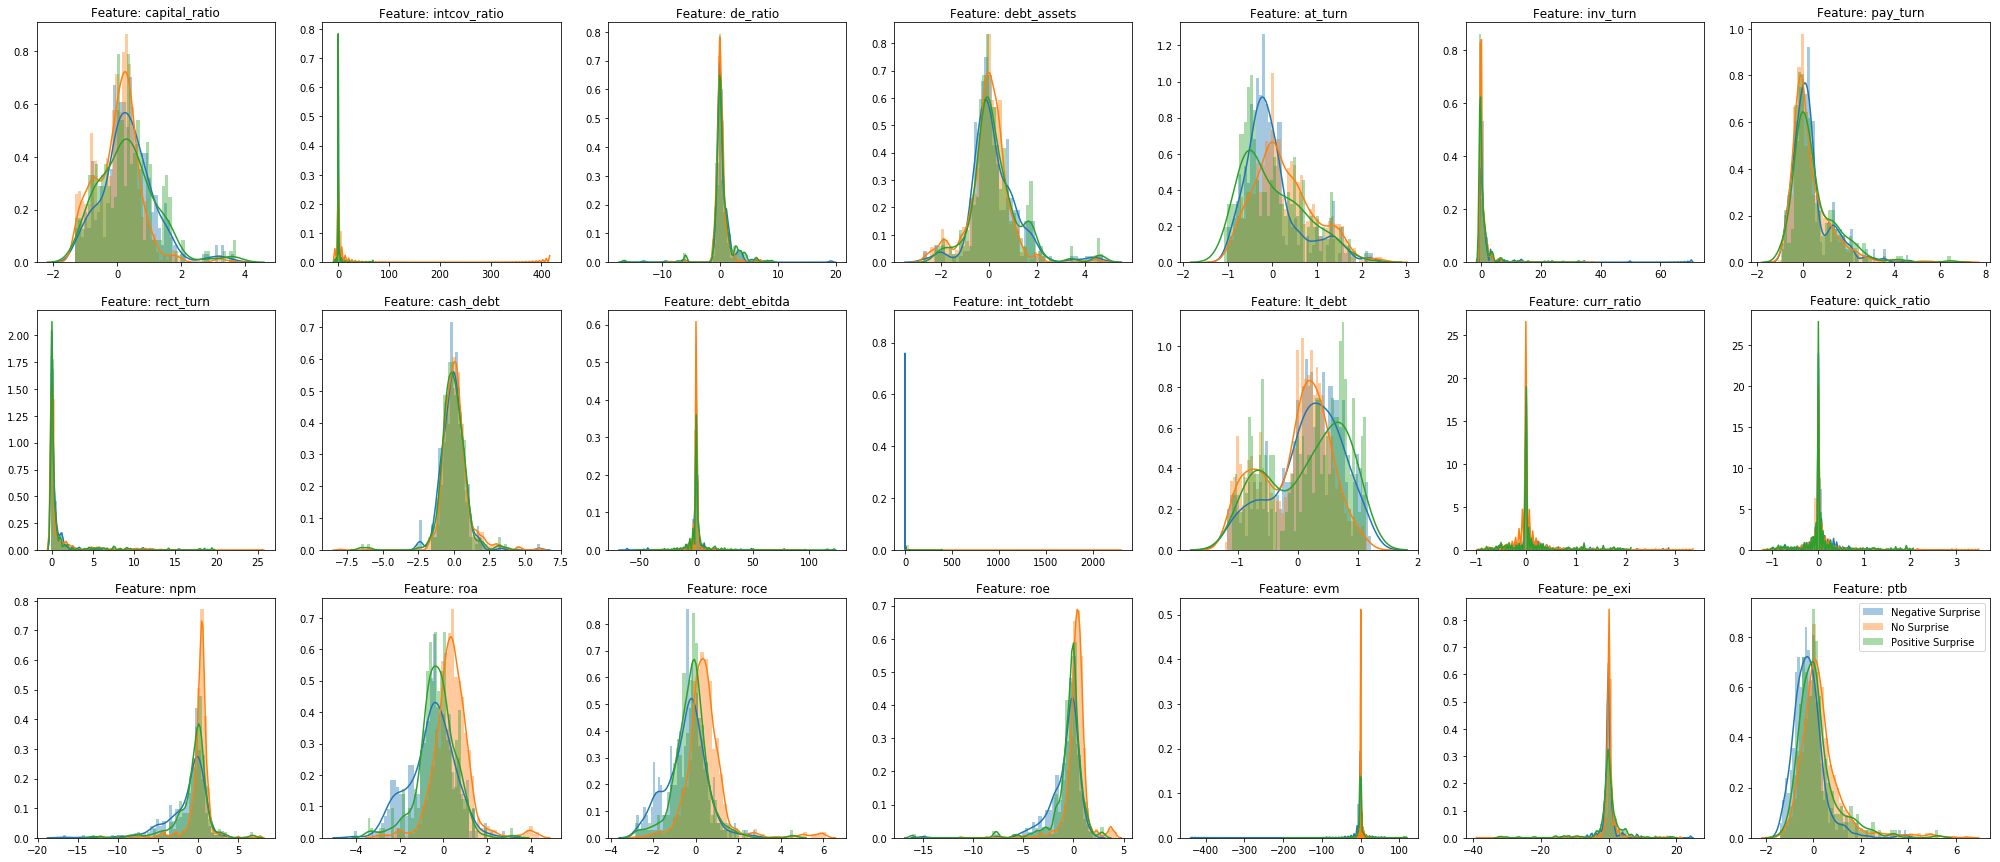

In [53]:
figsize = (35,15)
plot_var_dist(train,fr,3,7, figsize)